<h2> 3.6 Featurizing text data with tfidf weighted </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [3]:
# avoid decoding problems
df = pd.read_csv("train.csv")
# df = df.head(5000)
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [4]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [5]:
print(df.shape)
df.head(1)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0


In [6]:
df1.head(1)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [7]:
df2.head(1)

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0


In [8]:
df = pd.merge(df, df1, on='id')

In [9]:
df = pd.merge(df, df2, on='id')

In [10]:
df.shape

(404290, 34)

In [11]:
print(df.shape)
print(df.columns)
df.head()

(404290, 34)
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate_x',
       'is_duplicate_y', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')


,id,qid1,qid2,question1,question2,is_duplicate_x,is_duplicate_y,cwc_min,cwc_max,csc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,0.999980,0.833319,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0,0.799984,0.399996,0.749981,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0,0.399992,0.333328,0.399992,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0,0.399992,0.199998,0.999950,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


## Splitting the data into Train and test

In [12]:
y_true = df['is_duplicate']
df = df.drop('is_duplicate', axis=1)
print(len(y_true))
df.head()

404290


,id,qid1,qid2,question1,question2,is_duplicate_x,is_duplicate_y,cwc_min,cwc_max,csc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,0.999980,0.833319,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0,0.799984,0.399996,0.749981,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0,0.399992,0.333328,0.399992,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0,0.399992,0.199998,0.999950,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3, random_state = 22)

### For hyperparameter tunning again splitting the dataset into train and cv

In [14]:
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3, random_state = 22)

In [15]:
# help(train_test_split)

In [16]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)


(198102, 33)
(84901, 33)
(121287, 33)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(X_train['question1']) + list(X_train['question2'])
questions_cv = list(X_cv['question1']) + list(X_cv['question2'])
questions_test = list(X_test['question1']) + list(X_test['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit(list(X_train['question1']) + list(X_train['question2']))
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
# X_train_tfidf_q1 = tfidf.transform(list(X_train['question1']))
# X_train_tfidf_q2 = tfidf.transform(list(X_train['question2']))

# X_test_tfidf_q1 = tfidf.transform(list(X_test['question1']))
# X_test_tfidf_q2 = tfidf.transform(list(X_test['question2']))




In [18]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('D:\Installation\Anaconda\Lib\site-packages\en_core_web_sm2\en_core_web_sm-2.1.0')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_cv['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_cv['q1_feats_m'] = list(vecs1)

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)


100%|██████████████████████████████████████████████████████████████████████████| 121287/121287 [24:01<00:00, 90.50it/s]


In [19]:
nlp = spacy.load('D:\Installation\Anaconda\Lib\site-packages\en_core_web_sm2\en_core_web_sm-2.1.0')

vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    # 384 is the number of dimensions of vectors 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu2 in tqdm(list(X_cv['question2'])):
    doc2 = nlp(qu2) 
    # 384 is the number of dimensions of vectors 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_cv['q2_feats_m'] = list(vecs2)

vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    # 384 is the number of dimensions of vectors 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)


100%|██████████████████████████████████████████████████████████████████████████| 121287/121287 [22:33<00:00, 89.62it/s]


In [20]:
X_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate_x',
       'is_duplicate_y', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'q1_feats_m',
       'q2_feats_m'],
      dtype='object')

In [21]:
X_trainq1 = pd.DataFrame(X_train.q1_feats_m.tolist(), index = X_train.index)
X_trainq2 = pd.DataFrame(X_train.q1_feats_m.tolist(), index = X_train.index)

X_cvq1 = pd.DataFrame(X_cv.q1_feats_m.tolist(), index = X_cv.index)
X_cvq2 = pd.DataFrame(X_cv.q1_feats_m.tolist(), index = X_cv.index)

X_testq1 = pd.DataFrame(X_test.q1_feats_m.tolist(), index = X_test.index)
X_testq2 = pd.DataFrame(X_test.q1_feats_m.tolist(), index = X_test.index)



In [22]:
if "question1" in X_train.columns:
    print("question1 is present")
    X_train = X_train.drop(["question1", "question2", "is_duplicate_x", "is_duplicate_y"], axis=1)
    X_cv = X_cv.drop(["question1", "question2", "is_duplicate_x", "is_duplicate_y"], axis=1)
    X_test = X_test.drop(["question1", "question2", "is_duplicate_x", "is_duplicate_y"], axis=1)

if "q1_feats_m" in X_train.columns:
    print("q1_feats_m is present")
    X_train = X_train.drop(["q1_feats_m", "q2_feats_m"], axis=1)
    X_cv = X_cv.drop(["q1_feats_m", "q2_feats_m"], axis=1)
    X_test = X_test.drop(["q1_feats_m", "q2_feats_m"], axis=1)

question1 is present
q1_feats_m is present


In [23]:

# ###########################TRAIN###################################
# cols = list(X_train.columns)
# for i in cols:
#     X_train[i] = X_train[i].apply(pd.to_numeric)
    
# cols = list(X_trainq1.columns)
# for i in cols:
#     X_trainq1[i] = X_trainq1[i].apply(pd.to_numeric)
    
# cols = list(X_trainq2.columns)
# for i in cols:
#     X_trainq2[i] = X_trainq2[i].apply(pd.to_numeric)
    
# ##############################TEST################################    
# cols = list(X_test.columns)
# for i in cols:
#     X_test[i] = X_test[i].apply(pd.to_numeric)
    
# cols = list(X_testq1.columns)
# for i in cols:
#     X_testq1[i] = X_testq1[i].apply(pd.to_numeric)
    
# cols = list(X_testq2.columns)
# for i in cols:
#     X_testq2[i] = X_testq2[i].apply(pd.to_numeric)
# #     print(i)
# #     print(i)

In [24]:
from scipy.sparse import hstack
X_train_tfidfaw2v = hstack((X_train, X_trainq1, X_trainq2))
X_cv_tfidfaw2v = hstack((X_cv, X_cvq1, X_cvq2))
X_test_tfidfaw2v = hstack((X_test, X_testq1, X_testq2))

In [25]:
# storing the final features to csv file
from scipy.sparse import hstack
import pickle

train_filename = 'X_train_final_features_tfidfaw2v'
cv_filename = 'X_cv_final_features_tfidfaw2v'
test_filename = 'X_test_final_features_tfidfaw2v'

if not os.path.isfile(train_filename):
    print("file not preset")
#     X_train = hstack((X_train_dfnlp, X_train_dfppro, X_train_tfidf_q1_5k, X_train_tfidf_q2_5k))
    file = open(train_filename, "wb")
    pickle.dump(X_train_tfidfaw2v, file)
    file.close()
    
if not os.path.isfile(cv_filename):
    print("file not preset")
#     X_train = hstack((X_train_dfnlp, X_train_dfppro, X_train_tfidf_q1_5k, X_train_tfidf_q2_5k))
    file = open(cv_filename, "wb")
    pickle.dump(X_cv_tfidfaw2v, file)
    file.close()
    
if not os.path.isfile(test_filename):
    print("file not preset")
#     X_test = hstack((X_test_dfnlp, X_test_dfppro, X_test_tfidf_q1_5k, X_test_tfidf_q2_5k))
    file = open(test_filename, "wb")
    pickle.dump(X_test_tfidfaw2v, file)
    file.close()
    
#     X_test.to_csv('final_features_test.csv')
#     df3_q1['id']=df1['id']
#     df3_q2['id']=df1['id']
#     df1  = df1.merge(df2, on='id',how='left')
#     df2  = df3_q1.merge(df3_q2, on='id',how='left')
#     result  = df1.merge(df2, on='id',how='left')
#     result.to_csv('final_features.csv')

file not preset
file not preset
file not preset


## Creating Machine Learning Models

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [27]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8862989870380212


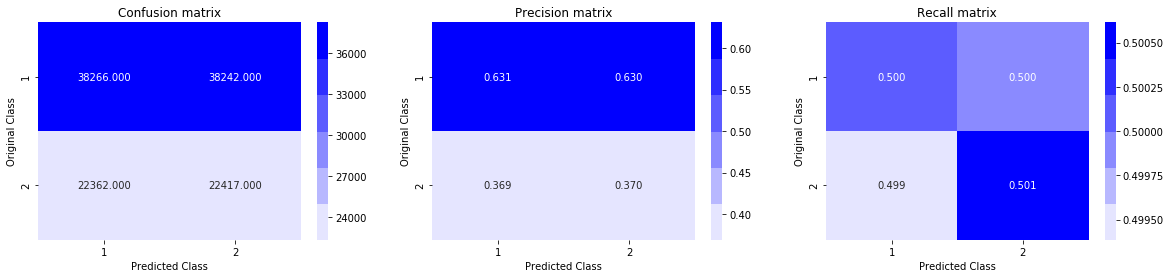

In [28]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with Hyper parameter Tunning

For values of alpha =  1e-05 The log loss is: 0.6585257000416679
For values of alpha =  0.0001 The log loss is: 0.6585257000416679
For values of alpha =  0.001 The log loss is: 0.6585257000416679
For values of alpha =  0.01 The log loss is: 0.6585257000416679
For values of alpha =  0.1 The log loss is: 0.6291808538782638
For values of alpha =  1 The log loss is: 0.6010622608479769
For values of alpha =  10 The log loss is: 0.6537582510254519


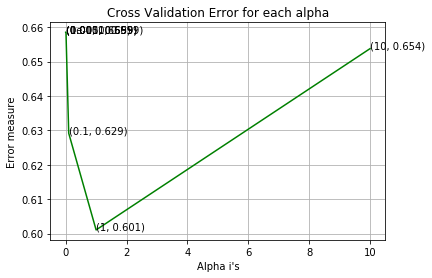

For values of best alpha =  1 The train log loss is: 0.6530464123359322
For values of best alpha =  1 The test log loss is: 0.6064044603870536
Total number of data points : 121287


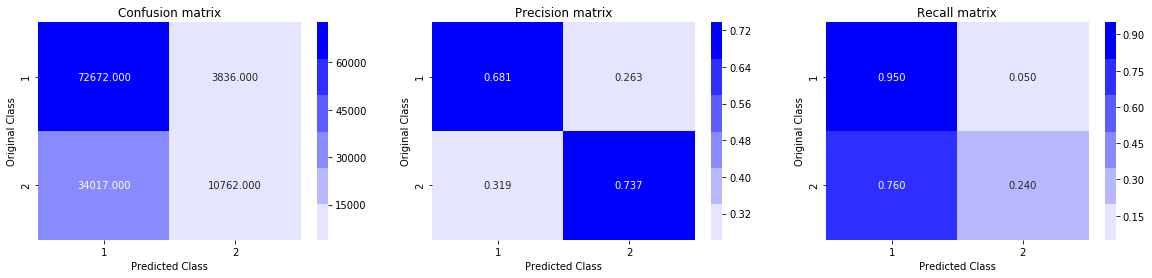

In [31]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_train=[]
log_error_cv=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(X_train_tfidfaw2v, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidfaw2v, y_train)
    y_hat_train = sig_clf.predict_proba(X_train_tfidfaw2v)
    y_hat_cv = sig_clf.predict_proba(X_cv_tfidfaw2v)
    log_error_train.append(log_loss(y_train, y_hat_train, labels=clf.classes_, eps=1e-15))
    log_error_cv.append(log_loss(y_cv, y_hat_cv, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, y_hat_cv, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_cv,c='g')
for i, txt in enumerate(np.round(log_error_cv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_cv[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_cv)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_tfidfaw2v, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidfaw2v, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidfaw2v)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_hat_train, labels=clf.classes_, eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test_tfidfaw2v)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15))
predicted_y_test =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y_test))
plot_confusion_matrix(y_test, predicted_y_test)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6585257000416679
For values of alpha =  0.0001 The log loss is: 0.6585257000416679
For values of alpha =  0.001 The log loss is: 0.6585257000416679
For values of alpha =  0.01 The log loss is: 0.6585257000416679
For values of alpha =  0.1 The log loss is: 0.6585257000416679
For values of alpha =  1 The log loss is: 0.6316221305524244
For values of alpha =  10 The log loss is: 0.6524296838263242


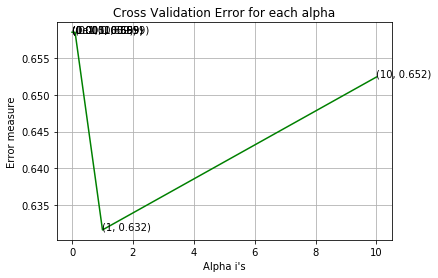

For values of best alpha =  1 The train log loss is: 0.6517066566715122
For values of best alpha =  1 The test log loss is: 0.6064044603870536
Total number of data points : 121287


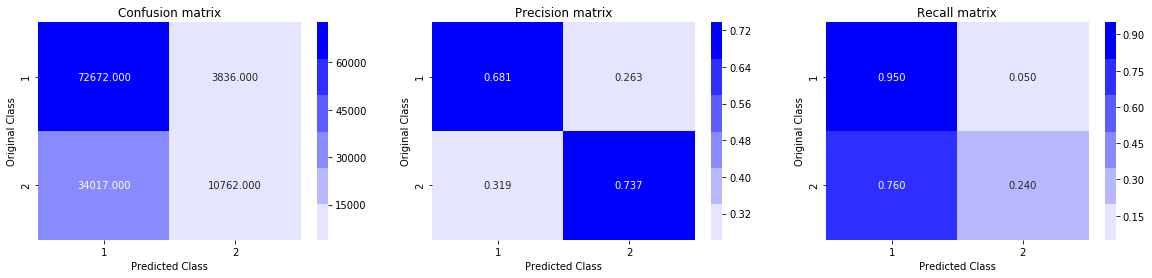

In [33]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_train=[]
log_error_cv=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_tfidfaw2v, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidfaw2v, y_train)
    y_hat_train = sig_clf.predict_proba(X_train_tfidfaw2v)
    y_hat_cv = sig_clf.predict_proba(X_cv_tfidfaw2v)
    log_error_train.append(log_loss(y_train, y_hat_train, labels=clf.classes_, eps=1e-15))
    log_error_cv.append(log_loss(y_cv, y_hat_cv, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, y_hat_cv, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_cv,c='g')
for i, txt in enumerate(np.round(log_error_cv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_cv[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_cv)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_tfidfaw2v, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidfaw2v, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidfaw2v)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_hat_train, labels=clf.classes_, eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test_tfidfaw2v)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15))
predicted_y_test =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y_test))
plot_confusion_matrix(y_test, predicted_y_test)

## 4.6 XGBoost

In [34]:
print(X_train.shape)
print(len(y_train))

(198102, 29)
198102


In [35]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_tfidfaw2v, label=y_train)
d_test = xgb.DMatrix(X_test_tfidfaw2v, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_tfidfaw2v,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684964	valid-logloss:0.685049
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615157	valid-logloss:0.615562
[20]	train-logloss:0.563852	valid-logloss:0.564538
[30]	train-logloss:0.525717	valid-logloss:0.526687
[40]	train-logloss:0.496168	valid-logloss:0.497289
[50]	train-logloss:0.473186	valid-logloss:0.47447
[60]	train-logloss:0.454683	valid-logloss:0.456177
[70]	train-logloss:0.439712	valid-logloss:0.441351
[80]	train-logloss:0.427771	valid-logloss:0.429538
[90]	train-logloss:0.417935	valid-logloss:0.419827
[100]	train-logloss:0.409825	valid-logloss:0.411868
[110]	train-logloss:0.402894	valid-logloss:0.405078
[120]	train-logloss:0.397187	valid-logloss:0.399432
[130]	train-logloss:0.392277	valid-logloss:0.394638
[140]	train-logloss:0.388112	valid-logloss:0.390544
[150]	train-logloss:0.384542	valid-logloss:0.387072
[160]	train-logloss:0.381335	

Total number of data points : 121287


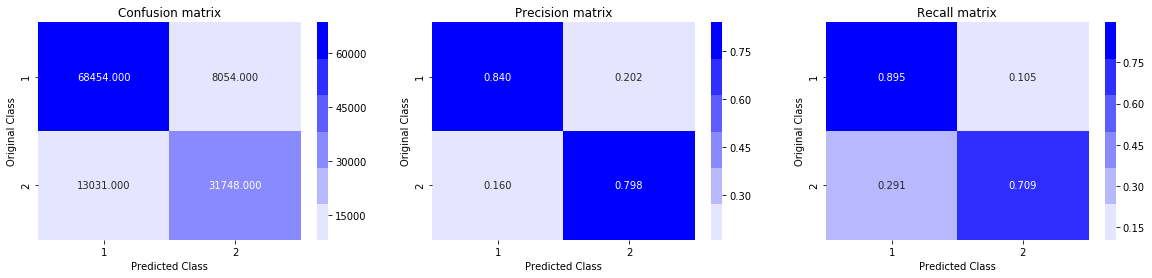

In [36]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Conclusion

In [37]:

from tabulate import tabulate
print("Score Comaprison")
headers = ["Sr. No","Model", "Train Loss", "Test Loss"]
columnValues= [
    
    [1, "Logistic Regression  - AW2V", "0.65", "0.60"],
    [2, "Linear SVM - AW2V", "0.65", "0.60"],
    [3, "XGBoost - AW2V", "0.34", "0.35"],
	
	
    [4, "Logistic Regression - TFIDF", "0.63", "0.63"],
    [5, "Linear SVM - TFIDF", "0.64", "0.64"],
    [6, "XGBoost - TFIDF ", "0.00017", "0.00017"],
 
]

print(tabulate(columnValues, headers, tablefmt="fancy_grid"))

Score Comaprison
╒══════════╤═════════════════════════════╤══════════════╤═════════════╕
│   Sr. No │ Model                       │   Train Loss │   Test Loss │
╞══════════╪═════════════════════════════╪══════════════╪═════════════╡
│        1 │ Logistic Regression  - AW2V │      0.65    │     0.6     │
├──────────┼─────────────────────────────┼──────────────┼─────────────┤
│        2 │ Linear SVM - AW2V           │      0.65    │     0.6     │
├──────────┼─────────────────────────────┼──────────────┼─────────────┤
│        3 │ XGBoost - AW2V              │      0.34    │     0.35    │
├──────────┼─────────────────────────────┼──────────────┼─────────────┤
│        4 │ Logistic Regression - TFIDF │      0.63    │     0.63    │
├──────────┼─────────────────────────────┼──────────────┼─────────────┤
│        5 │ Linear SVM - TFIDF          │      0.64    │     0.64    │
├──────────┼─────────────────────────────┼──────────────┼─────────────┤
│        6 │ XGBoost - TFIDF             │     